Importing all the libaries.

In [80]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import os, random, itertools


from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torchvision
from torchvision import transforms, models
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')




Test if Pytorch is working by printing out a random tensor.

In [81]:
imageLocations = 'lesion_dataset/data' 

labels = {'nv': 'Melanocytic nevi','mel': 'Melanoma','bkl': 'Benign keratosis-like lesions ','bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses','vasc': 'Vascular lesions','df': 'Dermatofibroma'
}

def splitUpImages(pic):
    temp = list(originalimages['lesion_id'])
    if pic in temp:
        return 'unique'
    else:
        return 'copy'

def TrainOrTest(i):
    temp = list(testDataframe['image_id'])
    if str(i) in temp:
        return 'test'
    else:
        return 'train'

metadata = 'lesion_dataset/HAM10000_metadata'
ogDataframe = pd.read_csv(metadata)



Create a dictionary of the image names to the image path

In [82]:

path = glob(os.path.join(imageLocations, '*.jpg'))
arrayOfPaths = {os.path.splitext(os.path.basename(i))[0]: i for i in path}

ogDataframe['path'] = ogDataframe['image_id'].map(arrayOfPaths.get)





Check the number of images to make sure all are present.
Print random plot of images to make suret they loaded in.

Number of Images:  10015


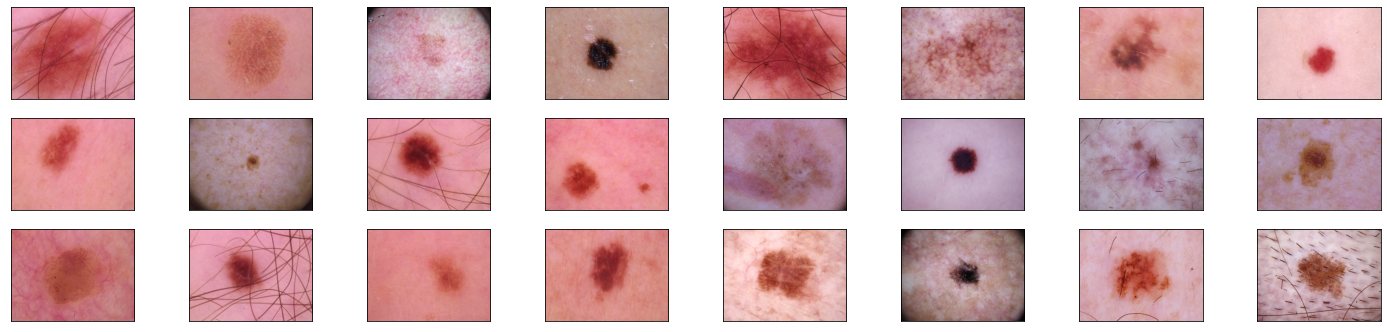

In [83]:

images = os.listdir(imageLocations)

print("Number of Images: ", len(images))


display_images = random.choices(images, k=24)

fig = plt.figure(figsize=(25, 16))

for i, img in enumerate(display_images):
    x = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    
    img = Image.open(os.path.join(imageLocations, img))
    plt.imshow(img)

Initialize the model and load it on the device

In [90]:

model = models.densenet121(pretrained=True)

#model.classifier = nn.Linear(inputNumber,NumberofDisease) Linears parameters are number of inputs and number of Diseases. 
#THis code is from Pytorch Documentation not sure what it does so we omitted it.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #pytorch docs cuda=gpu
model = model.to(device)




Transform images

In [91]:
#resize images to 224x224 for Densnet standrds with pytorch documentation for tranformations
trainingTransform = transforms.Compose([transforms.Resize((224,224)),transforms.ColorJitter(brightness=0.15, contrast=0.1, hue=0.1),
                                      transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),transforms.RandomRotation(degrees=15),
                                      transforms.ColorJitter(brightness=0.15, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))])

testTransform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))])

Create a dataloader using the Pytorch Dataloader class

In [92]:
#class created via documentation found here https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class Dataloader(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = Image.open(self.data['path'][index])
        imageLabel = torch.tensor(int(self.data['identification'][index]))

        if self.transform:
            image = self.transform(image)

        return image, imageLabel

Load the transforms and datasets using the Dataloader

In [93]:

trainSplit, testDataframe = train_test_split(images, test_size=0.2, random_state=101, stratify= 7)


transformTrImage = Dataloader(ogDataframe, transform=trainingTransform)
transformTeImage = Dataloader(testDataframe, transform=testTransform)


Get optimizer and loss function

In [94]:
#from pytorch documentation, just used most popular optimizer and loss function
#Optimizer changes weights and 

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

Calculate training loss and accuracy using AverageMeter from pytorch

In [95]:
#from https://kaiyangzhou.github.io/deep-person-reid/_modules/torchreid/utils/avgmeter.html which was submitted to pytorch as OpenSource

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

run the training

In [96]:
trainDataloader = DataLoader(transformTrImage, batch_size=32, shuffle=True)
testDataloader = DataLoader(transformTeImage, batch_size=32, shuffle=False)

numOfCycles = 1
accuracy = 0
finalTrLoss, finalTrAccuracy = [],[]
finalTeLoss, finalTeAccuracy = [],[]
for cycle in range(1, numOfCycles+1):
    generalTrLoss = AverageMeter()
    generalTrAccuracy = AverageMeter()
    numComplete = (cycle - 1) * len(trainDataloader)
    for i, data in enumerate(trainDataloader):
        images, imageLabel = data
        imageSize = images.size(0)
        # print('image shape:',images.size(0), 'label shape',imageLabel.size(0))
        images = Variable(images).to(device)
        imageLabel = Variable(imageLabel).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, imageLabel)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        generalTrAccuracy.update(prediction.eq(imageLabel.view_as(prediction)).sum().item()/imageSize)
        generalTrLoss.update(loss.item())
        numComplete += 1
        if (i + 1) % 1 == 0:
            print('[cycle %d], [Number completed %d / %d], [Training accuracy %.5f]' % (
                cycle, i + 1, len(trainDataloader), generalTrAccuracy.avg))
            finalTrLoss.append(generalTrLoss.avg)
            finalTrAccuracy.append(generalTrAccuracy.avg)

    generalTeLoss = AverageMeter()
    generalTeAccuracy = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(testDataloader):
            images, imageLabel = data
            imageSize = images.size(0)
            images = Variable(images).to(device)
            imageLabel = Variable(imageLabel).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            generalTeAccuracy.update(prediction.eq(imageLabel.view_as(prediction)).sum().item()/imageSize)

            generalTeLoss.update(criterion(outputs, imageLabel).item())

    finalTeLoss.append(str(generalTeLoss))
    finalTeAccuracy.append(str(generalTeAccuracy))
    if int(generalTeAccuracy.avg) > accuracy:
        accuracy = generalTeAccuracy
        print('best record: [cycle %d], [Testing accuracy %.5f]' % (cycle, generalTeAccuracy.avg))

torch.save(model, 'model.pth')

[cycle 1], [Number completed 1 / 1124], [Training accuracy 0.00000]
[cycle 1], [Number completed 2 / 1124], [Training accuracy 0.00000]
[cycle 1], [Number completed 3 / 1124], [Training accuracy 0.05208]
[cycle 1], [Number completed 4 / 1124], [Training accuracy 0.12500]
[cycle 1], [Number completed 5 / 1124], [Training accuracy 0.15000]
[cycle 1], [Number completed 6 / 1124], [Training accuracy 0.19271]
[cycle 1], [Number completed 7 / 1124], [Training accuracy 0.20536]
[cycle 1], [Number completed 8 / 1124], [Training accuracy 0.22266]
[cycle 1], [Number completed 9 / 1124], [Training accuracy 0.24653]
[cycle 1], [Number completed 10 / 1124], [Training accuracy 0.26250]
[cycle 1], [Number completed 11 / 1124], [Training accuracy 0.27841]
[cycle 1], [Number completed 12 / 1124], [Training accuracy 0.28646]
[cycle 1], [Number completed 13 / 1124], [Training accuracy 0.28125]
[cycle 1], [Number completed 14 / 1124], [Training accuracy 0.28795]
[cycle 1], [Number completed 15 / 1124], [T

KeyboardInterrupt: 

In [ ]:
#create confusion matrix with sklearn documentation
def createMatrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
  

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#created using sk learn documentation
model.eval()
yaxis = []
predict = []
with torch.no_grad():
    for i, data in enumerate(testDataloader):
        images, labels = data
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        yaxis.extend(labels.cpu().numpy())
        predict.extend(np.squeeze(prediction.cpu().numpy().T))

confusionMatrix = confusion_matrix(yaxis, predict)

labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
createMatrix(confusionMatrix, labels)

# Generate a classification report from sk learn library
stats = classification_report(yaxis, predict, target_names=labels)
print(stats)



torch.save(model, 'model.pth')

files.download('model.pth')